In [1]:
import sys
sys.executable

'/Users/eranagmon/code/process-bigraph/venv/bin/python'

In [2]:
import numpy as np
from process_bigraph import Process, ProcessTypes, Composite
import matplotlib.pyplot as plt
import cobra
from cobra.io import load_model
from scipy.ndimage import convolve

import imageio.v2 as imageio
import io
import base64
from IPython.display import display, HTML

core = ProcessTypes()


In [3]:
# create new types
def apply_non_negative(schema, current, update, core):
    new_value = current + update
    return max(0, new_value)

positive_float = {
    '_type': 'positive_float',
    '_inherit': 'float',
    '_apply': apply_non_negative
}
core.register('positive_float', positive_float)

bounds_type = {
    'lower': 'maybe[float]',
    'upper': 'maybe[float]'
}
core.register_process('bounds', bounds_type)

In [4]:
core.access('positive_float')

{'_type': 'positive_float',
 '_check': 'check_float',
 '_apply': 'apply_non_negative',
 '_serialize': 'to_string',
 '_description': '64-bit floating point precision number',
 '_default': '0.0',
 '_deserialize': 'deserialize_float',
 '_divide': 'divide_float',
 '_dataclass': 'dataclass_float',
 '_inherit': ['float']}

## Helper Functions

In [5]:
def sort_results(results):
    emitter_results = results[('emitter',)]
    sorted_results = {'fields': {
        key: [] for key in emitter_results[0]['fields'].keys()
    }, 'time': []}

    for results in emitter_results:
        time = results['time']
        fields = results['fields']
        sorted_results['time'].append(time)
        for key, value in fields.items():
            sorted_results['fields'][key].append(value)     
    return sorted_results

def plot_time_series(results, field_names=None, coordinates=None):
    """
    Plots time series for specified fields and coordinates from the results dictionary.

    :param results: Dictionary containing the results with keys 'time' and 'fields'.
                    Example: {'time': [0.1, 0.2, 0.3 ...], 'fields': {'glucose': [nparray_time0, nparray_time1], ...}}
    :param field_names: List of field names to plot.
                        Example: ['glucose', 'other chemical']
    :param coordinates: List of coordinates (indices) to plot.
                        Example: [(0, 0), (1, 2)]
    """
    coordinates = coordinates or [(0, 0)]
    field_names = field_names or ['glucose', 'acetate', 'biomass']
    sorted_results = sort_results(results)
    time = sorted_results['time']
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for field_name in field_names:
        if field_name in sorted_results['fields']:
            field_data = sorted_results['fields'][field_name]
            
            for coord in coordinates:
                x, y = coord
                time_series = [field_data[t][x, y] for t in range(len(time))]
                ax.plot(time, time_series, label=f'{field_name} at {coord}')
        else:
            print(f"Field '{field_name}' not found in results['fields']")
    
    # Adding plot labels and legend
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title('Time Series Plot')
    ax.legend()
    
    # Display the plot
    plt.show()

def plot_snapshots(results, field_names, times):
    """
    Plots snapshots of specified fields at specified times from the results dictionary.

    :param results: Dictionary containing the results with keys 'time' and 'fields'.
                    Example: {'time': [0.1, 0.2, 0.3 ...], 'fields': {'glucose': [nparray_time0, nparray_time1], ...}}
    :param field_names: List of field names to plot.
                        Example: ['glucose', 'other chemical']
    :param times: List of times at which to plot the snapshots.
                  Example: [0.1, 0.3]
    """
    sorted_results = sort_results(results)
    time_indices = [sorted_results['time'].index(t) for t in times]
    
    num_rows = len(times)
    num_cols = len(field_names)
    
    # Compute global min and max for each field
    global_min_max = {}
    for field_name in field_names:
        field_data_all_times = np.concatenate([sorted_results['fields'][field_name][t].flatten() for t in range(len(sorted_results['time']))])
        global_min_max[field_name] = (np.min(field_data_all_times), np.max(field_data_all_times))
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
    
    for row, time_index in enumerate(time_indices):
        for col, field_name in enumerate(field_names):
            if field_name in sorted_results['fields']:
                field_data = sorted_results['fields'][field_name][time_index]
                ax = axes[row, col] if num_rows > 1 and num_cols > 1 else (axes[row] if num_rows > 1 else axes[col])
                im = ax.imshow(field_data, cmap='viridis', aspect='auto', 
                               vmin=global_min_max[field_name][0], vmax=global_min_max[field_name][1])
                ax.set_title(f'{field_name} at t={sorted_results["time"][time_index]}')
                fig.colorbar(im, ax=ax)
            else:
                print(f"Field '{field_name}' not found in results['fields']")
    
    plt.tight_layout()
    plt.show()
    
def plot_species_distributions_to_gif(results, filename='species_distribution.gif', title='', skip_frames=1):
    sorted_results = sort_results(results)
    species_names = [key for key in sorted_results['fields'].keys()]
    n_species = len(species_names)
    times = sorted_results['time']
    n_times = len(times)

    # Compute global min and max for each species
    global_min_max = {species: (np.min(np.concatenate([sorted_results['fields'][species][i].flatten() for i in range(n_times)])), 
                                np.max(np.concatenate([sorted_results['fields'][species][i].flatten() for i in range(n_times)]))) 
                      for species in species_names}
    
    images = []
    for i in range(0, n_times, skip_frames):
        fig, axs = plt.subplots(1, n_species, figsize=(5 * n_species, 4))
        if n_species == 1:
            axs = [axs]
        
        for j, species in enumerate(species_names):
            ax = axs[j]
            vmin, vmax = global_min_max[species]
            img = ax.imshow(sorted_results['fields'][species][i], interpolation='nearest', vmin=vmin, vmax=vmax)
            ax.set_title(f'{species} at t = {times[i]:.2f}')
            plt.colorbar(img, ax=ax)
        
        fig.suptitle(title, fontsize=16)
        plt.subplots_adjust(wspace=0.05, hspace=0.2)  # Adjust subplot spacing
        plt.tight_layout(pad=0.2)

        # Save the current figure to a temporary buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=120)
        buf.seek(0)
        images.append(imageio.imread(buf))
        buf.close()
        plt.close(fig)
    
    # Create and save the GIF with loop=0 for infinite loop
    imageio.mimsave(filename, images, duration=0.5, loop=0)

    # Optionally display the GIF in a Jupyter notebook
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    display(HTML(f'<img src="{data_url}" alt="{title}" style="max-width:100%;"/>'))

## Dynamic FBA Process

In [6]:
class DynamicFBA(Process):
    """
    Performs dynamic FBA.

    Parameters:
    - model: The metabolic model for the simulation.
    - kinetic_params: Kinetic parameters (Km and Vmax) for each substrate.
    - biomass_reaction: The identifier for the biomass reaction in the model.
    - substrate_update_reactions: A dictionary mapping substrates to their update reactions.
    - biomass_identifier: The identifier for biomass in the current state.

    TODO -- check units
    """

    config_schema = {
        'model_file': 'string',
        'kinetic_params': 'map[tuple[float,float]]',
        'biomass_reaction': {
            '_type': 'string',
            '_default': 'Biomass_Ecoli_core'
        },
        'substrate_update_reactions': 'map[string]',
        'biomass_identifier': 'string',
        'bounds': 'map[bounds]',
    }

    def __init__(self, config, core):
        super().__init__(config, core)

        if not 'xml' in self.config['model_file']:
            # use the textbook model if no model file is provided
            self.model = load_model(self.config['model_file'])
        else:
            self.model = cobra.io.read_sbml_model(self.config['model_file'])

        for reaction_id, bounds in self.config['bounds'].items():
            if bounds['lower'] is not None:
                self.model.reactions.get_by_id(reaction_id).lower_bound = bounds['lower']
            if bounds['upper'] is not None:
                self.model.reactions.get_by_id(reaction_id).upper_bound = bounds['upper']

    def inputs(self):
        return {
            'substrates': 'map[positive_float]'
        }

    def outputs(self):
        return {
            'substrates': 'map[positive_float]'
        }

    # TODO -- can we just put the inputs/outputs directly in the function?
    def update(self, state, interval):
        substrates_input = state['substrates']

        for substrate, reaction_id in self.config['substrate_update_reactions'].items():
            Km, Vmax = self.config['kinetic_params'][substrate]
            substrate_concentration = substrates_input[substrate]
            uptake_rate = Vmax * substrate_concentration / (Km + substrate_concentration)
            self.model.reactions.get_by_id(reaction_id).lower_bound = -uptake_rate

        substrate_update = {}

        solution = self.model.optimize()
        if solution.status == 'optimal':
            current_biomass = substrates_input[self.config['biomass_identifier']]
            biomass_growth_rate = solution.fluxes[self.config['biomass_reaction']]
            substrate_update[self.config['biomass_identifier']] = biomass_growth_rate * current_biomass * interval

            for substrate, reaction_id in self.config['substrate_update_reactions'].items():
                flux = solution.fluxes[reaction_id]
                substrate_update[substrate] = flux * current_biomass * interval
                # TODO -- assert not negative?
        else:
            # Handle non-optimal solutions if necessary
            # print('Non-optimal solution, skipping update')
            for substrate, reaction_id in self.config['substrate_update_reactions'].items():
                substrate_update[substrate] = 0

        return {
            'substrates': substrate_update,
        }

core.register_process('DynamicFBA', DynamicFBA)


def dfba_config(
        model_file='textbook',
        kinetic_params=None,
        biomass_reaction='Biomass_Ecoli_core',
        substrate_update_reactions=None,
        biomass_identifier='biomass',
        bounds=None
):
    if bounds is None:
        bounds = {
            'EX_o2_e': {'lower': -2, 'upper': None},
            'ATPM': {'lower': 1, 'upper': 1}}
    if substrate_update_reactions is None:
        substrate_update_reactions = {
            'glucose': 'EX_glc__D_e',
            'acetate': 'EX_ac_e'}
    if kinetic_params is None:
        kinetic_params = {
            'glucose': (0.5, 1),
            'acetate': (0.5, 2)}
    return {
        'model_file': model_file,
        'kinetic_params': kinetic_params,
        'biomass_reaction': biomass_reaction,
        'substrate_update_reactions': substrate_update_reactions,
        'biomass_identifier': biomass_identifier,
        'bounds': bounds
    }


In [7]:
from process_bigraph.experiments.parameter_scan import RunProcess

# TODO -- this should be imported, or just part of Process?
def run_process(
        address,
        config,
        core_type,
        initial_state,
        observables,
        timestep=1,
        runtime=10
):
    config = {
        'process_address': address,
        'process_config': config,
        'observables': observables,
        'timestep': timestep,
        'runtime': runtime}

    run = RunProcess(config, core_type)
    return run.update(initial_state)

### Running Dynamic FBA Example

In [8]:
n_bins = (5, 5)

initial_glucose = np.random.uniform(low=0, high=20, size=n_bins)
initial_acetate = np.random.uniform(low=0, high=0, size=n_bins)
initial_biomass = np.random.uniform(low=0, high=0.1, size=n_bins)

dfba_processes_dict = {}
for i in range(n_bins[0]):
    for j in range(n_bins[1]):
        dfba_processes_dict[f'[{i},{j}]'] = {
            '_type': 'process',
            'address': 'local:DynamicFBA',
            'config': dfba_config(),
            'inputs': {
                'substrates': {
                    'glucose': ['..', 'fields', 'glucose', i, j],
                    'acetate': ['..', 'fields', 'acetate', i, j],
                    'biomass': ['..', 'fields', 'biomass', i, j],
                }
            },
            'outputs': {
                'substrates': {
                    'glucose': ['..', 'fields', 'glucose', i, j],
                    'acetate': ['..', 'fields', 'acetate', i, j],
                    'biomass': ['..', 'fields', 'biomass', i, j]
                }
            }
        }

composite_state = {
    'fields': {
        '_type': 'map',
        '_value': {
            '_type': 'array',
            '_shape': n_bins,
            '_data': 'positive_float'
        },
        'glucose': initial_glucose,
        'acetate': initial_acetate,
        'biomass': initial_biomass,
    },
    'spatial_dfba': dfba_processes_dict,
    'emitter': {
        '_type': 'step',
        'address': 'local:ram-emitter',
        'config': {
            'emit': {
                'fields': 'map',
                'time': 'float',
            }
        },
        'inputs': {
            'fields': ['fields'],
            'time': ['global_time']
        }
    }
}

sim = Composite({'state': composite_state}, core=core)

sim.update({}, 60.0)
dfba_results = sim.gather_results()

/Users/eranagmon/code/process-bigraph/venv/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


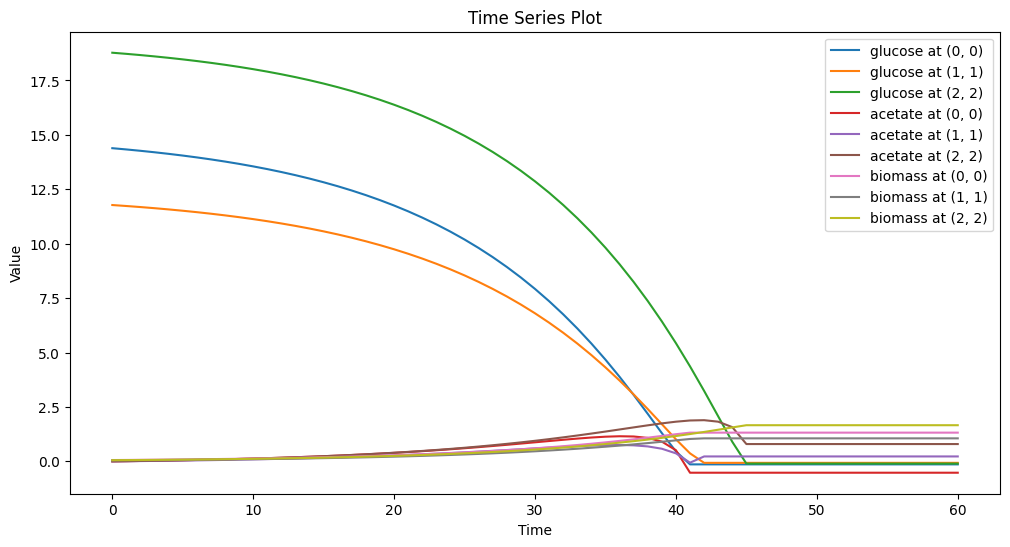

In [9]:
plot_time_series(
    dfba_results, 
    coordinates=[(0, 0), (1, 1), (2, 2)],
)

## Diffusion Advection Process

In [10]:
# Laplacian for 2D diffusion
LAPLACIAN_2D = np.array([[0, 1, 0],
                         [1, -4, 1],
                         [0, 1, 0]])


class DiffusionAdvection(Process):
    config_schema = {
        'n_bins': 'tuple[integer,integer]',
        'bounds': 'tuple[float,float]',
        'default_diffusion_rate': {'_type': 'float', '_default': 1e-1},
        'default_diffusion_dt': {'_type': 'float', '_default': 1e-1},
        'diffusion_coeffs': 'map[float]',
        'advection_coeffs': 'map[tuple[float,float]]',
    }

    def __init__(self, config, core):
        super().__init__(config, core)

        # get diffusion rates
        bins_x = self.config['n_bins'][0]
        bins_y = self.config['n_bins'][1]
        length_x = self.config['bounds'][0]
        length_y = self.config['bounds'][1]
        dx = length_x / bins_x
        dy = length_y / bins_y
        dx2 = dx * dy

        # general diffusion rate
        diffusion_rate = self.config['default_diffusion_rate']
        self.diffusion_rate = diffusion_rate / dx2

        # diffusion rates for each individual molecules
        self.molecule_specific_diffusion = {
            mol_id: diff_rate / dx2
            for mol_id, diff_rate in self.config['diffusion_coeffs'].items()}

        # get diffusion timestep
        diffusion_dt = 0.5 * dx ** 2 * dy ** 2 / (2 * diffusion_rate * (dx ** 2 + dy ** 2))
        self.diffusion_dt = min(diffusion_dt, self.config['default_diffusion_dt'])

    def inputs(self):
        return {
            'fields': {
                '_type': 'map',
                '_value': {
                    '_type': 'array',
                    '_shape': self.config['n_bins'],
                    '_data': 'positive_float'
                },
            }
        }

    def outputs(self):
        return {
            'fields': {
                '_type': 'map',
                '_value': {
                    '_type': 'array',
                    '_shape': self.config['n_bins'],
                    '_data': 'positive_float'
                },
            }
        }

    def update(self, state, interval):
        fields = state['fields']

        fields_update = {}
        for species, field in fields.items():
            fields_update[species] = self.diffusion_delta(
                field,
                interval,
                diffusion_coeff=self.config['diffusion_coeffs'][species],
                advection_coeff=self.config['advection_coeffs'][species]
            )

        return {
            'fields': fields_update
        }

    def diffusion_delta(self, state, interval, diffusion_coeff, advection_coeff):
        t = 0.0
        dt = min(interval, self.diffusion_dt)
        updated_state = state.copy()

        while t < interval:

            # Diffusion
            laplacian = convolve(
                updated_state,
                LAPLACIAN_2D,
                mode='reflect',
            ) * diffusion_coeff

            # Advection
            advective_flux_x = convolve(
                updated_state,
                np.array([[-1, 0, 1]]),
                mode='reflect',
            ) * advection_coeff[0]
            advective_flux_y = convolve(
                updated_state,
                np.array([[-1], [0], [1]]),
                mode='reflect',
            ) * advection_coeff[1]

            # Update the current state
            updated_state += (laplacian + advective_flux_x + advective_flux_y) * dt

            # # Ensure non-negativity
            # current_states[species] = np.maximum(updated_state, 0)

            # Update time
            t += dt

        return updated_state - state

core.register_process('DiffusionAdvection', DiffusionAdvection)

### Running Diffusion Advection Example

In [20]:
n_bins = (10, 10)
bounds = (10, 10)

initial_A = np.random.uniform(low=0, high=20, size=n_bins)
initial_B = np.random.uniform(low=0, high=0, size=n_bins)
initial_C = np.random.uniform(low=0, high=0.1, size=n_bins)

composite_state = {
    'fields': {
        'A': initial_A,
        'B': initial_B,
        'C': initial_C,
    },
    'diffusion': {
        '_type': 'process',
        'address': 'local:DiffusionAdvection',
        'config': {
            'n_bins': n_bins,
            'bounds': bounds,
            'default_diffusion_rate': 1e-1,
            'default_diffusion_dt': 1e-1,
            'diffusion_coeffs': {
                'A': 1e-1,
                'B': 1e-1,
                'C': 1e-2,
            },
            'advection_coeffs': {
                'A': (0, 0),
                'B': (0, 0),
                'C': (0, -0.10),
            },
        },
        'inputs': {
            'fields': ['fields']
        },
        'outputs': {
            'fields': ['fields']
        }
    },
    'emitter': {
        '_type': 'step',
        'address': 'local:ram-emitter',
        'config': {
            'emit': {
                'fields': 'map',
                'time': 'float',
            }
        },
        'inputs': {
            'fields': ['fields'],
            'time': ['global_time'],
        }
    }
}

sim = Composite({'state': composite_state}, core=core)
# sim.add_emitter()
sim.update({}, 60.0)

diffadv_results = sim.gather_results()


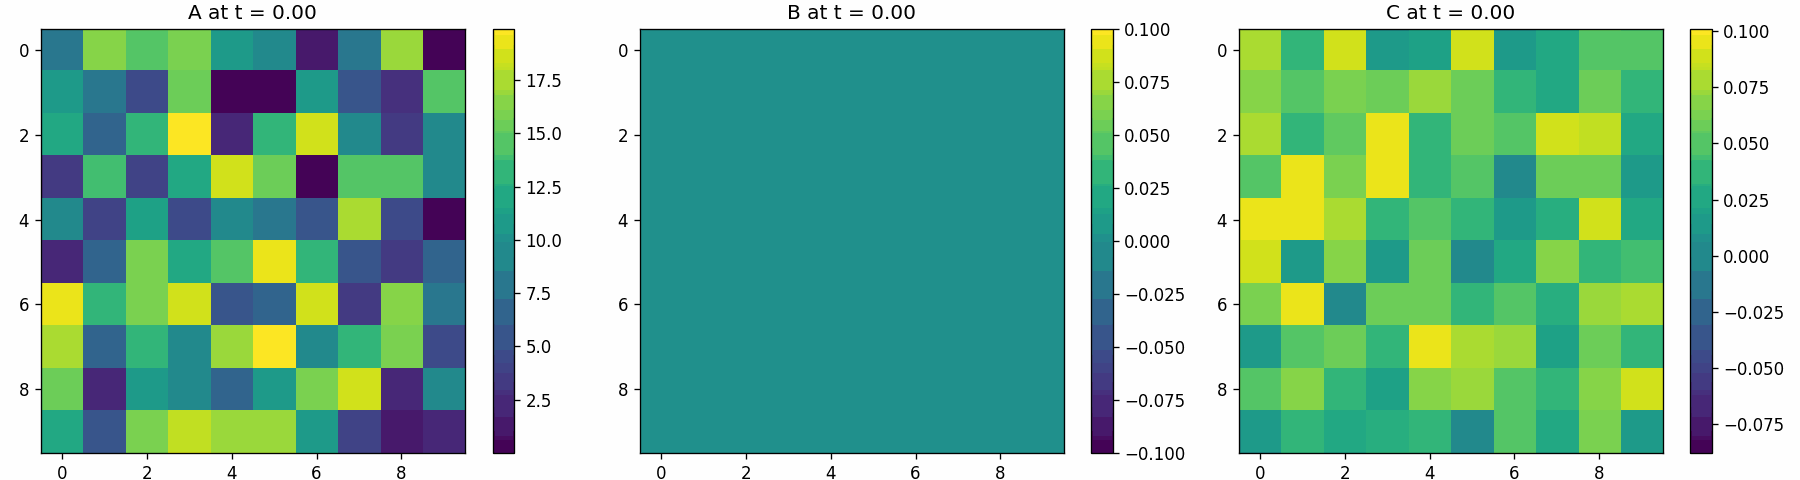

In [21]:
plot_species_distributions_to_gif(diffadv_results, filename='diffadv_results.gif', title='', skip_frames=1)

## COMETS Composite

In [13]:
def get_comets(
        n_bins=(20, 20),
        bounds=(10, 10),
):
    initial_glucose = np.random.uniform(low=0, high=20, size=n_bins)
    initial_acetate = np.random.uniform(low=0, high=0, size=n_bins)
    initial_biomass = np.random.uniform(low=0, high=0.1, size=n_bins)
    
    dfba_processes_dict = {}
    for i in range(n_bins[0]):
        for j in range(n_bins[1]):
            dfba_processes_dict[f'[{i},{j}]'] = {
                '_type': 'process',
                'address': 'local:DynamicFBA',
                'config': dfba_config(),
                'inputs': {
                    'substrates': {
                        'glucose': ['..', 'fields', 'glucose', i, j],
                        'acetate': ['..', 'fields', 'acetate', i, j],
                        'biomass': ['..', 'fields', 'biomass', i, j],
                    }
                },
                'outputs': {
                    'substrates': {
                        'glucose': ['..', 'fields', 'glucose', i, j],
                        'acetate': ['..', 'fields', 'acetate', i, j],
                        'biomass': ['..', 'fields', 'biomass', i, j]
                    }
                }
            }
    
    composite_state = {
        'fields': {
            '_type': 'map',
            '_value': {
                '_type': 'array',
                '_shape': n_bins,
                '_data': 'positive_float'
            },
            'glucose': initial_glucose,
            'acetate': initial_acetate,
            'biomass': initial_biomass,
        },
        'spatial_dfba': dfba_processes_dict,
        'diffusion': {
            '_type': 'process',
            'address': 'local:DiffusionAdvection',
            'config': {
                'n_bins': n_bins,
                'bounds': bounds,
                'default_diffusion_rate': 1e-1,
                'default_diffusion_dt': 1e-1,
                'diffusion_coeffs': {
                    'glucose': 1e-1,
                    'acetate': 1e-1,
                    'biomass': 1e-1,
                },
                'advection_coeffs': {
                    'glucose': (0, 0),
                    'acetate': (0, 0),
                    'biomass': (0, 0),
                },
            },
            'inputs': {
                'fields': ['fields']
            },
            'outputs': {
                'fields': ['fields']
            }
        },
        'emitter': {
            '_type': 'step',
            'address': 'local:ram-emitter',
            'config': {
                'emit': {
                    'fields': 'map',
                    'time': 'float',
                }
            },
            'inputs': {
                'fields': ['fields'],
                'time': ['global_time']
            }
        }
    }
    return composite_state

def run_comets(composite_state, runtime=10):
    sim = Composite({'state': composite_state}, core=core)
    sim.update({}, runtime)
    return sim.gather_results()


### Running COMETS example

In [14]:
comets_config = get_comets()
comets_results = run_comets(comets_config, runtime=10)
# print(results)

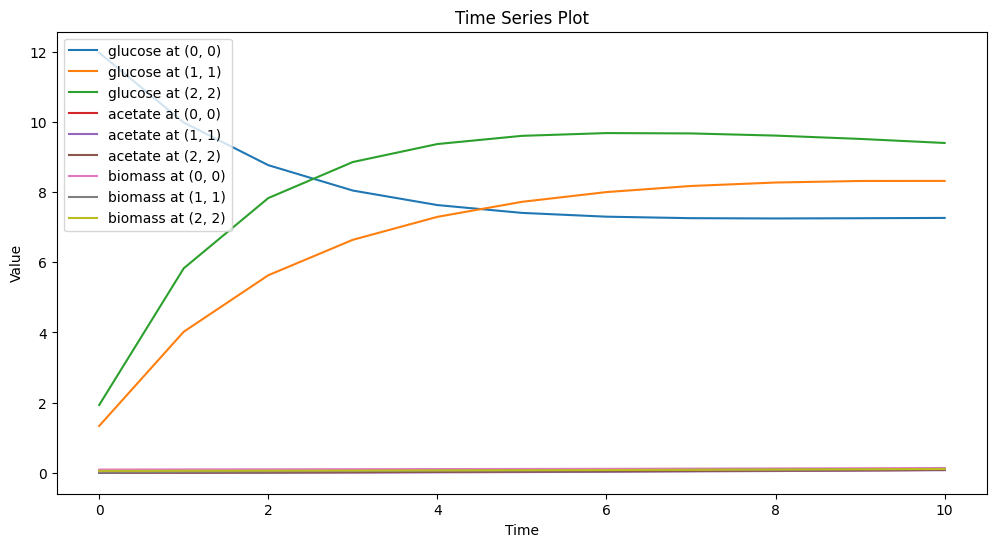

In [15]:
plot_time_series(
    comets_results, 
    coordinates=[(0, 0), (1, 1), (2, 2)],
)


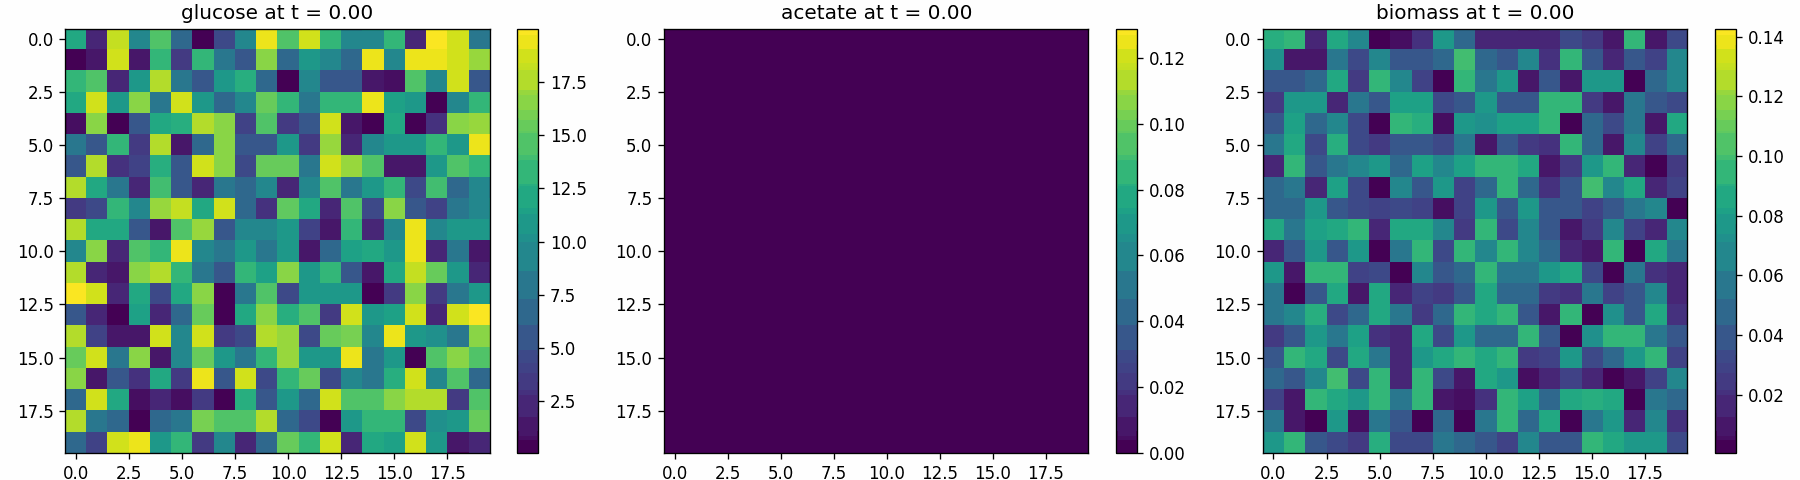

In [16]:
plot_species_distributions_to_gif(comets_results, filename='comets_results.gif', title='', skip_frames=1)

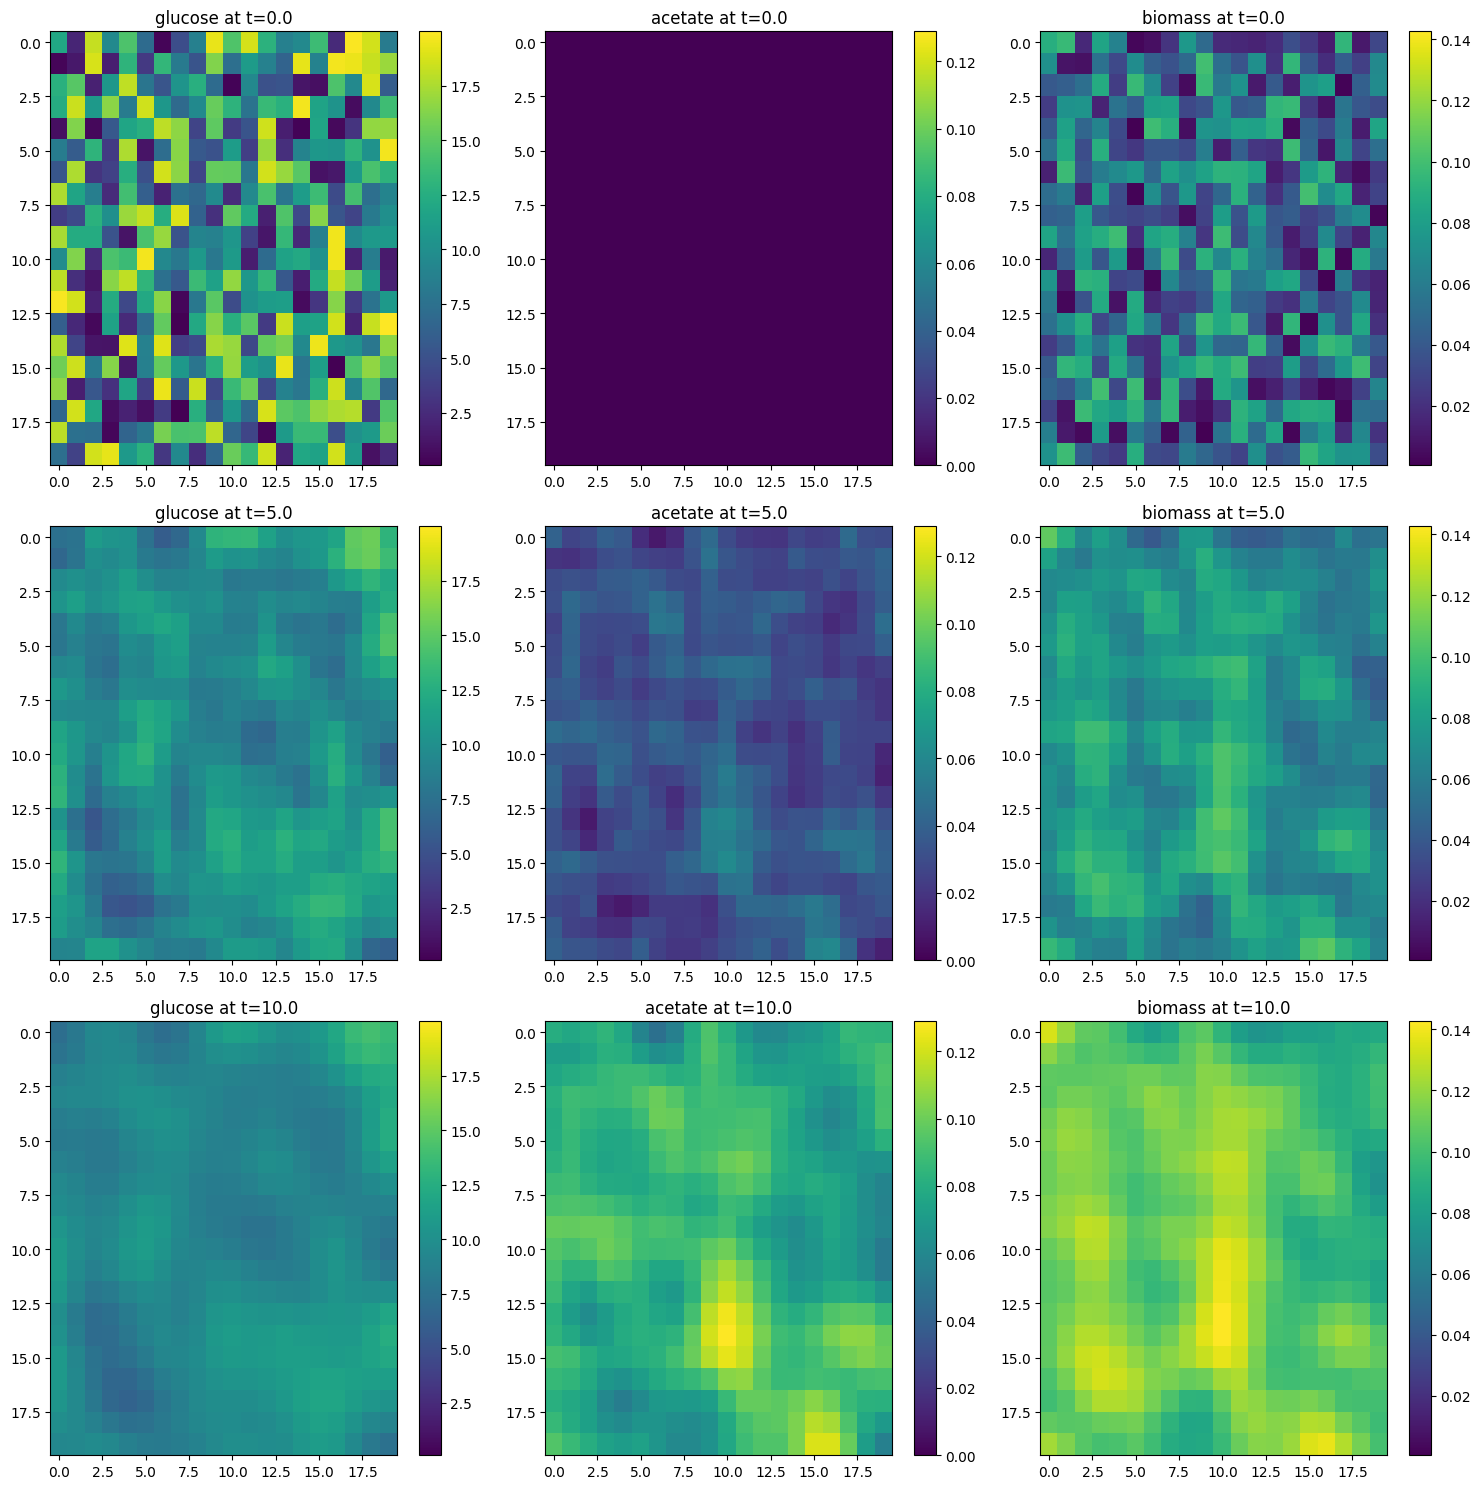

In [17]:
plot_snapshots(comets_results, field_names=['glucose', 'acetate', 'biomass'], times=[0.0, 5.0, 10.0])